# BOLD monitoring using a basal ganglia model

Download the Jupyter notebook: [BoldParkinson.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/BoldParkinson.ipynb){target="_blank"} or run it directly on  [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/BoldParkinson.ipynb){target="_blank"}

Partial reproduction of:

Maith, O., Escudero, F. V., Dinkelbach, H. Ü., Baladron, J., Horn, A., Irmen, F., et al. \
**A computational model-based analysis of basal ganglia pathway changes in Parkinson’s disease inferred from resting-state fMRI.**\
*European Journal of Neuroscience*. [doi:10.1111/ejn.14868](https://doi.org/10.1111/ejn.14868)

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt


from ANNarchy import *
from ANNarchy.extensions.bold import BoldMonitor, BoldModel
from ANNarchy.extensions.bold.NormProjection import NormProjection

clear()

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


## Data

Below is the correlation matrix of the fMRI resting states of six areas :

1. GPe
2. GPI
3. STN
4. Cortex
5. Striatum
6. Thalamus

for a given patient. We want to fit some unknown hyperparameters of a basal ganglia model to this particular data.

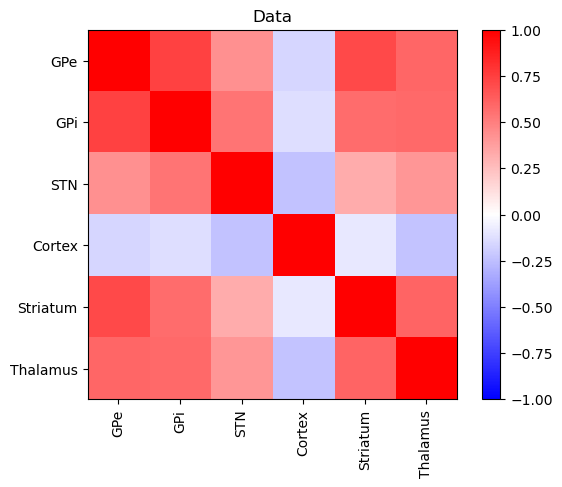

In [3]:
corr_mat_experiment = [
    [ 1.         , 0.7404208  , 0.43226027 ,-0.1593407  , 0.71059084 , 0.5998113 ],
    [ 0.7404208  , 1.         , 0.5438787  ,-0.12846166 , 0.5740793  , 0.58351475],
    [ 0.43226027 , 0.5438787  , 1.         ,-0.23731637 , 0.3270468  , 0.4103379 ],
    [-0.1593407  ,-0.12846166 ,-0.23731637 , 1.         ,-0.08617731 ,-0.23299724],
    [ 0.71059084 , 0.5740793  , 0.3270468  ,-0.08617731 , 1.         , 0.6047172 ],
    [ 0.5998113  , 0.58351475 , 0.4103379  ,-0.23299724 , 0.6047172  , 1.        ],
]

plt.figure()
plt.imshow(corr_mat_experiment, vmin=-1, vmax=1, cmap="bwr")
plt.title("Data")
plt.xticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"], rotation='vertical')
plt.yticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"])
plt.colorbar()
plt.show()

## Neuro-computational model

Let's first define the neuron models used in the network, as variations of the Izhikevich neuron:

In [4]:
Hybrid_neuron = Neuron(
    parameters="""
    a = 0.0   
    b = 0.0   
    c = 0.0   
    d = 0.0   
    n0 = 140. 
    n1 = 5.0  
    n2 = 0.04 
    I = 0.0   
    tau_ampa = 10 
    tau_gaba = 10 
    E_ampa = 0.0 
    E_gaba = -90.0 
    tau_syn = 1.0
    SteadyStateNoise = 0.0
    baseline = 0.0
    tau_noise=200.
""",
    equations="""
    dg_ampa/dt = -g_ampa/tau_ampa : init = 0
    dg_gaba/dt = -g_gaba/tau_gaba : init = 0
    dslowNoise/dt = (-slowNoise+SteadyStateNoise)/tau_noise : init = 0
    dv/dt = n2*v*v+n1*v+n0 - u  + I - g_ampa*(v-E_ampa) - g_gaba*(v-E_gaba) + slowNoise + baseline : init = -70.
    du/dt = a*(b*(v)-u) : init = -18.55
    tau_syn*dsyn/dt = -syn 
""",
    spike="""
    v>=30
""",
    reset="""
    v = c
    u = u+d
""",
    refractory=10.0,
)

Striatum_neuron = Neuron(
    parameters="""
    a = 0.05       
    b = -20.0      
    c = -55.0      
    d = 377        
    n0 = 61.65119  
    n1 = 2.594639  
    n2 = 0.022799  
    I = 0.0        
    tau_ampa = 10  
    tau_gaba = 10  
    E_ampa = 0.0   
    E_gaba = -90.0 
    Vr = -80.      
    C  = 50.       
    tau_syn = 1.0
    SteadyStateNoise = 0.0
    tau_noise=200.
    baseline=0.0
""",
    equations="""
    dg_ampa/dt = -g_ampa/tau_ampa : init = 0
    dg_gaba/dt = -g_gaba/tau_gaba : init = 0 
    dslowNoise/dt = (-slowNoise+SteadyStateNoise)/tau_noise : init = 0
    dv/dt = n2*v*v+n1*v+n0 - u/C  + I/C - g_ampa*(v-E_ampa) - g_gaba*(v-E_gaba)  + slowNoise + baseline : init = -70.
    du/dt = a*(b*(v-Vr)-u) : init = -18.55
    tau_syn*dsyn/dt = -syn 
""",
    spike="""
    v>=40
""",
    reset="""
    v = c
    u = u+d
""",
    refractory=10.0,
)

Here are some fixed parameters for the simulation:

In [5]:
# Some global definitions
timestep = 0.1
seedVal = 10
setup(dt=timestep, suppress_warnings=True, seed=seedVal)
rng = np.random.default_rng(seed=seedVal)

# General parameters
population_size = 200
numberOfNeuronsCortex = 600

# synaptic activity noise (max-)amplitude
noiseSYAC = 0.05  # 0.15

# how often changes the noise
noiseFrequency = 1000.0  # every x ms

# times in ms
initial_simulate = 15000.0
simulationduration = 250000.0

# baselines
Cortex_baseline = 50
CortexInhib_baseline = 0
SD1_baseline = 0
SD2_baseline = 0
GPi_baseline = 30
GPe_baseline = 12
STN_baseline = 3
Thalamus_baseline = 3.5

# noise in population
Cortex_noise_mean = 0
Cortex_noise_sd = 10
SD1_noise_mean = 0
SD1_noise_sd = 2
SD2_noise_mean = 0
SD2_noise_sd = 2
GPi_noise_mean = 0
GPi_noise_sd = 3
GPe_noise_mean = 0
GPe_noise_sd = 5
STN_noise_mean = 0
STN_noise_sd = 2
Thalamus_noise_mean = 0
Thalamus_noise_sd = 2

# noise change over time
Cortex_noise_delta = 5
SD1_noise_delta = 0
SD2_noise_delta = 0
GPi_noise_delta = 0
GPe_noise_delta = 0
STN_noise_delta = 0
Thalamus_noise_delta = 0

and here are the parameters that were found as a result of the hyperparameter optimization for this data sample:

In [6]:
fitted_con_params = {
    "D1GPi_probs": 0.17029162198305128,
    "D2GPe_probs": 0.4074640914797783,
    "GPeSTN_probs": 0.18478520214557648,
    "STNGPe_probs": 0.4119542151689529,
    "STNGPi_probs": 0.2458414003252983,
    "GPeGPi_probs": 0.32317305132746693,
    "GPeGPe_probs": 0.3238955348730087,
    "GPiGPi_probs": 0.31747561842203137,
    "GPiThal_probs": 0.25937364250421524,
    "ThalSD2_probs": 0.1753483198583126,
    "ThalSD1_probs": 0.12791343107819556,
    "SD1SD1_probs": 0.44881010577082636,
    "SD2SD2_probs": 0.20492168664932248,
    "CSD1_probs": 0.19523878321051596,
    "CSD2_probs": 0.10281952470540998,
    "CSTN_probs": 0.16828824281692503,
    "V1Inh_probs": 0.41263159513473513,
    "InhV1_probs": 0.21300644502043722,
    "InhInh_probs": 0.34024816900491717,
    "D1GPi_weights": 0.009132171887904406,
    "D2GPe_weights": 0.007663531694561243,
    "GPeSTN_weights": 0.006760342903435231,
    "STNGPe_weights": 0.010754598900675774,
    "STNGPi_weights": 0.013566167578101158,
    "GPeGPi_weights": 0.006238304376602173,
    "GPeGPe_weights": 0.007731672264635564,
    "GPiGPi_weights": 0.011985597293823957,
    "GPiThal_weights": 0.006650131419301033,
    "ThalSD2_weights": 0.006984027139842511,
    "ThalSD1_weights": 0.012284493483603,
    "SD1SD1_weights": 0.008113504592329264,
    "SD2SD2_weights": 0.013962633926421403,
    "CSD1_weights": 0.013000000000000001,
    "CSD2_weights": 0.010670950431376695,
    "CSTN_weights": 0.01283267229795456,
    "V1Inh_weights": 0.00956317337229848,
    "InhV1_weights": 0.012076521553099155,
    "InhInh_weights": 0.009441683050245047
}

We create the populations:

In [7]:
# Cortex
popV1 = Population(geometry=numberOfNeuronsCortex, neuron=Hybrid_neuron, name="V1")
popInhibit = Population(geometry=numberOfNeuronsCortex / 4, neuron=Hybrid_neuron)

popV1.a = 0.02
popV1.b = 0.2
popV1.c = -72
popV1.d = 6
popV1.I = 0.0
popV1.v = -72
popV1.u = -14
popV1.baseline = Cortex_baseline

popInhibit.a = 0.02
popInhibit.b = 0.2
popInhibit.c = -72
popInhibit.d = 6
popInhibit.I = 0.0
popInhibit.v = -72
popInhibit.u = -14
popInhibit.baseline = CortexInhib_baseline

# other layers
SD1 = Population(population_size, Striatum_neuron, name="SD1")
SD2 = Population(population_size, Striatum_neuron, name="SD2")
GPi = Population(population_size, Hybrid_neuron, name="GPi")
GPe = Population(population_size, Hybrid_neuron, name="GPe")
STN = Population(population_size, Hybrid_neuron, name="STN")
Thalamus = Population(population_size, Hybrid_neuron, name="Thalamus")

# GPi parameters
GPi.a = 0.005
GPi.b = 0.585
GPi.c = -65.0
GPi.d = 4.0
GPi.I = 0.0  # 10
GPi.baseline = GPi_baseline  # 2.5

# GPe parameters
GPe.a = 0.005
GPe.b = 0.585
GPe.c = -65
GPe.d = 4
GPe.I = 0.0
GPe.baseline = GPe_baseline  # 1.2

# STN parameters
STN.a = 0.005
STN.b = 0.265
STN.c = -65
STN.d = 2.0
STN.I = 0.0
STN.baseline = STN_baseline

# Thalamus parameters
Thalamus.a = 0.02
Thalamus.b = 0.25
Thalamus.c = -65
Thalamus.d = 0.05
Thalamus.I = 0.0
Thalamus.baseline = Thalamus_baseline

and the projections.

Note: We use `NormProjection` instead of `Projection` for backwards compatibility...

In [8]:
projV1_Inhib = NormProjection(
    pre=popV1,
    post=popInhibit,
    target="ampa",
    name="V1Inh",
    variable="syn",
).connect_fixed_probability(
    probability=fitted_con_params["V1Inh_probs"],
    weights=fitted_con_params["V1Inh_weights"],
    force_multiple_weights=True,
)

projInhib_V1 = NormProjection(
    pre=popInhibit,
    post=popV1,
    target="gaba",
    variable="syn",
    name="InhV1",
).connect_fixed_probability(
    probability=fitted_con_params["InhV1_probs"],
    weights=fitted_con_params["InhV1_weights"],
    force_multiple_weights=True,
)

projInhib_Lat = NormProjection(
    pre=popInhibit,
    post=popInhibit,
    target="gaba",
    variable="syn",
    name="InhInh",
).connect_fixed_probability(
    probability=fitted_con_params["InhInh_probs"],
    weights=fitted_con_params["InhInh_weights"],
    force_multiple_weights=True,
)

D1GPi = NormProjection(
    pre=SD1,
    post=GPi,
    target="gaba",
    variable="syn",
    name="D1GPi",
).connect_fixed_probability(
    probability=fitted_con_params["D1GPi_probs"],
    weights=fitted_con_params["D1GPi_weights"],
    force_multiple_weights=True,
)

D2GPe = NormProjection(
    pre=SD2,
    post=GPe,
    target="gaba",
    variable="syn",
    name="D2GPe",
).connect_fixed_probability(
    probability=fitted_con_params["D2GPe_probs"],
    weights=fitted_con_params["D2GPe_weights"],
    force_multiple_weights=True,
)

GPeSTN = NormProjection(
    pre=GPe,
    post=STN,
    target="gaba",
    variable="syn",
    name="GPeSTN",
).connect_fixed_probability(
    probability=fitted_con_params["GPeSTN_probs"],
    weights=fitted_con_params["GPeSTN_weights"],
    force_multiple_weights=True,
)

STNGPe = NormProjection(
    pre=STN,
    post=GPe,
    target="ampa",
    variable="syn",
    name="STNGPe",
).connect_fixed_probability(
    probability=fitted_con_params["STNGPe_probs"],
    weights=fitted_con_params["STNGPe_weights"],
    force_multiple_weights=True,
)

STNGPi = NormProjection(
    pre=STN,
    post=GPi,
    target="ampa",
    variable="syn",
    name="STNGPi",
).connect_fixed_probability(
    probability=fitted_con_params["STNGPi_probs"],
    weights=fitted_con_params["STNGPi_weights"],
    force_multiple_weights=True,
)

GPeGPi = NormProjection(
    pre=GPe,
    post=GPi,
    target="gaba",
    variable="syn",
    name="GPeGPi",
).connect_fixed_probability(
    probability=fitted_con_params["GPeGPi_probs"],
    weights=fitted_con_params["GPeGPi_weights"],
    force_multiple_weights=True,
)

GPeGPe = NormProjection(
    pre=GPe,
    post=GPe,
    target="gaba",
    variable="syn",
    name="GPeGPe",
).connect_fixed_probability(
    probability=fitted_con_params["GPeGPe_probs"],
    weights=fitted_con_params["GPeGPe_weights"],
    force_multiple_weights=True,
)

GPiGPi = NormProjection(
    pre=GPi,
    post=GPi,
    target="gaba",
    variable="syn",
    name="GPiGPi",
).connect_fixed_probability(
    probability=fitted_con_params["GPiGPi_probs"],
    weights=fitted_con_params["GPiGPi_weights"],
    force_multiple_weights=True,
)


GPiThal = NormProjection(
    pre=GPi,
    post=Thalamus,
    target="gaba",
    variable="syn",
    name="GPiThal",
).connect_fixed_probability(
    probability=fitted_con_params["GPiThal_probs"],
    weights=fitted_con_params["GPiThal_weights"],
    force_multiple_weights=True,
)

ThalSD2 = NormProjection(
    pre=Thalamus,
    post=SD2,
    target="ampa",
    variable="syn",
    name="ThalSD2",
).connect_fixed_probability(
    probability=fitted_con_params["ThalSD2_probs"],
    weights=fitted_con_params["ThalSD2_weights"],
    force_multiple_weights=True,
)

ThalSD1 = NormProjection(
    pre=Thalamus,
    post=SD1,
    target="ampa",
    variable="syn",
    name="ThalSD1",
).connect_fixed_probability(
    probability=fitted_con_params["ThalSD1_probs"],
    weights=fitted_con_params["ThalSD1_weights"],
    force_multiple_weights=True,
)

SD1SD1 = NormProjection(
    pre=SD1,
    post=SD1,
    target="gaba",
    variable="syn",
    name="SD1SD1",
).connect_fixed_probability(
    probability=fitted_con_params["SD1SD1_probs"],
    weights=fitted_con_params["SD1SD1_weights"],
    force_multiple_weights=True,
)

SD2SD2 = NormProjection(
    pre=SD2,
    post=SD2,
    target="gaba",
    variable="syn",
    name="SD2SD2",
).connect_fixed_probability(
    probability=fitted_con_params["SD2SD2_probs"],
    weights=fitted_con_params["SD2SD2_weights"],
    force_multiple_weights=True,
)

CSD1 = NormProjection(
    pre=popV1,
    post=SD1,
    target="ampa",
    variable="syn",
    name="CSD1",
).connect_fixed_probability(
    probability=fitted_con_params["CSD1_probs"],
    weights=fitted_con_params["CSD1_weights"],
    force_multiple_weights=True,
)

CSD2 = NormProjection(
    pre=popV1,
    post=SD2,
    target="ampa",
    variable="syn",
    name="CSD2",
).connect_fixed_probability(
    probability=fitted_con_params["CSD2_probs"],
    weights=fitted_con_params["CSD2_weights"],
    force_multiple_weights=True,
)

CSTN = NormProjection(
    pre=popV1,
    post=STN,
    target="ampa",
    variable="syn",
    name="CSTN",
).connect_fixed_probability(
    probability=fitted_con_params["CSTN_probs"],
    weights=fitted_con_params["CSTN_weights"],
    force_multiple_weights=True,
)

## Bold monitoring

We used a custom Balloon model:

In [9]:
balloon_maith2021 = BoldModel(
    parameters="""
            second    = 1000.0
            phi       = 1.0
            kappa     = 0.665
            gamma     = 0.412
            E_0       = 0.3424
            tau       = 1.0368
            alpha     = 0.3215
            V_0       = 0.02
            noise     = 0
        """,
    equations="""
            I_CBF          = sum(I_CBF) + noise                                         : init=0
            ds/dt          = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second      : init=0
            df_in/dt       = s / second                                                 : init=1, min=0.01

            E              = 1 - (1 - E_0)**(1 / f_in)                                  : init=0.3424
            dq/dt          = (f_in * E / E_0 - (q / v) * f_out)/(tau*second)            : init=1, min=0.01
            dv/dt          = (f_in - f_out)/(tau*second)                                : init=1, min=0.01
            f_out          = v**(1 / alpha)                                             : init=1, min=0.01

            k_1            = 7 * E_0
            k_2            = 2
            k_3            = 2 * E_0 - 0.2

            BOLD           = V_0 * (k_1 * (1 - q) + k_2 * (1 - (q / v)) + k_3 * (1 - v)) : init=0
        """,
    inputs="I_CBF",
    output="BOLD"
)

and record BOLD signals in all BG areas:

In [10]:
m_bold_GPe = BoldMonitor(
    GPe,
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    start=True,
)
m_bold_GPi = BoldMonitor(
    GPi,
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    start=True,
)
m_bold_STN = BoldMonitor(
    STN,
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    start=True,
)
m_bold_Strboth = BoldMonitor(
    [SD1, SD2],
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    scale_factor=[1, 1],
    start=True,
)
m_bold_Thal = BoldMonitor(
    Thalamus,
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    start=True,
)
m_bold_Cortex = BoldMonitor(
    [popV1, popInhibit],
    balloon_maith2021,
    mapping={"I_CBF": "syn"},
    scale_factor=[1, 1],
    start=True,
)

## Simulation

In [11]:
compile()

Compiling ...  OK 


In [12]:
def simulateNoisePeriods(duration):
    try:
        if duration % noiseFrequency != 0:
            raise ValueError(
                "duration ("
                + str(duration)
                + ") has to be a multiple of noiseFrequency"
            )
    except ValueError as ve:
        print(ve)
        exit(1)

    for NoisePeriod in range(int(duration / noiseFrequency)):
        popV1.SteadyStateNoise = rng.normal(
            Cortex_noise_mean + rng.uniform(-Cortex_noise_delta, Cortex_noise_delta),
            Cortex_noise_sd,
            popV1.geometry,
        )
        SD1.SteadyStateNoise = rng.normal(
            SD1_noise_mean + rng.uniform(-SD1_noise_delta, SD1_noise_delta),
            SD1_noise_sd,
            SD1.geometry,
        )
        SD2.SteadyStateNoise = rng.normal(
            SD2_noise_mean + rng.uniform(-SD2_noise_delta, SD2_noise_delta),
            SD2_noise_sd,
            SD2.geometry,
        )
        GPi.SteadyStateNoise = rng.normal(
            GPi_noise_mean + rng.uniform(-GPi_noise_delta, GPi_noise_delta),
            GPi_noise_sd,
            GPi.geometry,
        )
        GPe.SteadyStateNoise = rng.normal(
            GPe_noise_mean + rng.uniform(-GPe_noise_delta, GPe_noise_delta),
            GPe_noise_sd,
            GPe.geometry,
        )
        STN.SteadyStateNoise = rng.normal(
            STN_noise_mean + rng.uniform(-STN_noise_delta, STN_noise_delta),
            STN_noise_sd,
            STN.geometry,
        )
        Thalamus.SteadyStateNoise = rng.normal(
            Thalamus_noise_mean
            + rng.uniform(-Thalamus_noise_delta, Thalamus_noise_delta),
            Thalamus_noise_sd,
            Thalamus.geometry,
        )

        m_bold_GPi.noise = rng.uniform(0, 1, 1) * noiseSYAC
        m_bold_GPe.noise = rng.uniform(0, 1, 1) * noiseSYAC
        m_bold_STN.noise = rng.uniform(0, 1, 1) * noiseSYAC
        m_bold_Strboth.noise = rng.uniform(0, 1, 1) * noiseSYAC
        m_bold_Thal.noise = rng.uniform(0, 1, 1) * noiseSYAC
        m_bold_Cortex.noise = rng.uniform(0, 1, 1) * noiseSYAC
        
        simulate(noiseFrequency)

In [13]:
# Bring the network into a stable state
simulateNoisePeriods(initial_simulate)

# Simulate the resting state
simulateNoisePeriods(simulationduration)

In [14]:
bCortex = m_bold_Cortex.get("BOLD")
bStrboth = m_bold_Strboth.get("BOLD")
bSTN = m_bold_STN.get("BOLD")
bGPi = m_bold_GPi.get("BOLD")
bGPe = m_bold_GPe.get("BOLD")
bThal = m_bold_Thal.get("BOLD")

bold_gpe_arr = bGPe[int(initial_simulate / timestep) :, 0]
bold_gpi_arr = bGPi[int(initial_simulate / timestep) :, 0]
bold_stn_arr = bSTN[int(initial_simulate / timestep) :, 0]
bold_cor_arr = bCortex[int(initial_simulate / timestep) :, 0]
bold_str_arr = bStrboth[int(initial_simulate / timestep) :, 0]
bold_tha_arr = bThal[int(initial_simulate / timestep) :, 0]

## Analysis

Let's visualize the BOLD signals over this quite long simulation (250 s)

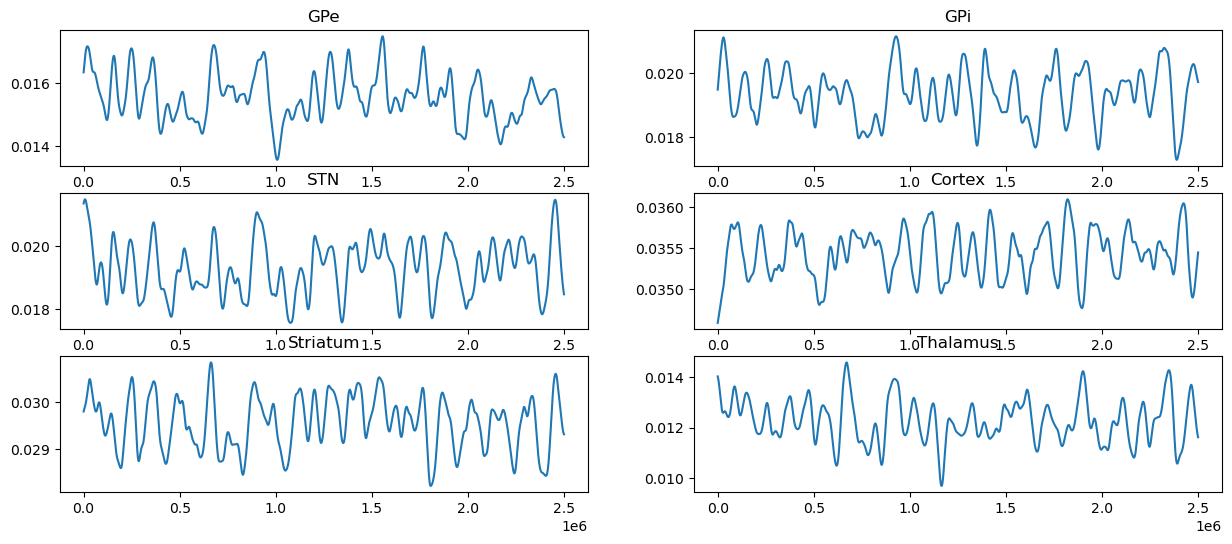

In [15]:
plt.figure(figsize=(15, 6))
plt.subplot(321)
plt.plot(bold_gpe_arr)
plt.title("GPe")
plt.subplot(322)
plt.plot(bold_gpi_arr)
plt.title("GPi")
plt.subplot(323)
plt.plot(bold_stn_arr)
plt.title("STN")
plt.subplot(324)
plt.plot(bold_cor_arr)
plt.title("Cortex")
plt.subplot(325)
plt.plot(bold_str_arr)
plt.title("Striatum")
plt.subplot(326)
plt.plot(bold_tha_arr)
plt.title("Thalamus")

plt.show()

We compute the correlation between each pair of these signals:

In [16]:
bold_arr_len = len(bold_gpe_arr)
time_step_list = list(
    range(int(bold_arr_len / 1000), bold_arr_len, int(bold_arr_len / 1000))
)
cor_list = []
for idx in time_step_list:
    cor_list.append(
        np.corrcoef(
            [
                bold_gpe_arr[:idx],
                bold_gpi_arr[:idx],
                bold_stn_arr[:idx],
                bold_cor_arr[:idx],
                bold_str_arr[:idx],
                bold_tha_arr[:idx],
            ]
        )
    )

We can now compare the correlation matrix of the simulation with the data:

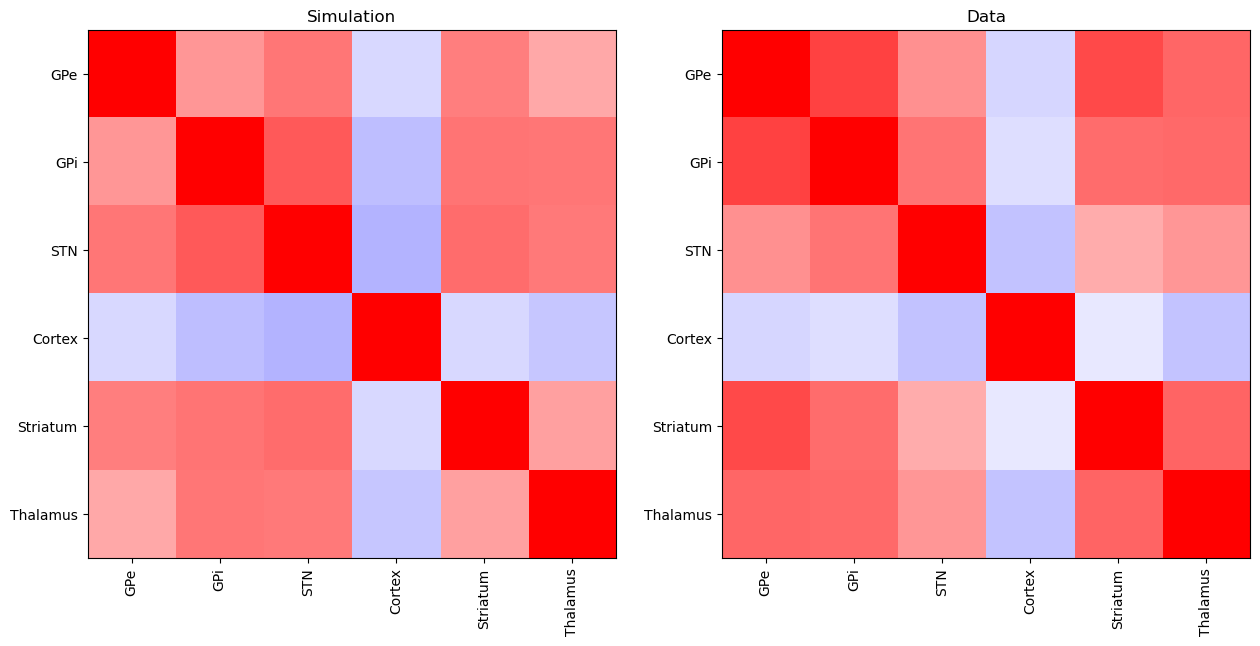

In [17]:
corr_mat_simulated = cor_list[-1]

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(corr_mat_simulated, vmin=-1, vmax=1, cmap="bwr")
plt.title("Simulation")
plt.xticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"], rotation='vertical')
plt.yticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"])

plt.subplot(122)
plt.imshow(corr_mat_experiment, vmin=-1, vmax=1, cmap="bwr")
plt.title("Data")
plt.xticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"], rotation='vertical')
plt.yticks([0, 1, 2, 3, 4, 5], labels=["GPe", "GPi", "STN", "Cortex", "Striatum", "Thalamus"])
plt.show()


The loss (difference between simulated and recorded correlation matrix) depends on the simulation length. The simulations must be long enough to support the hypotheses.

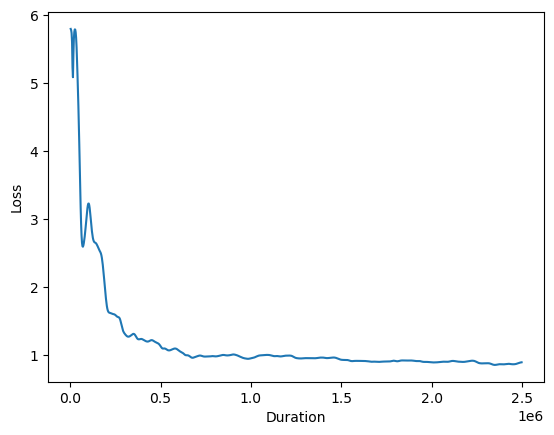

In [18]:
loss_list = []
for cor in cor_list:
    loss_list.append(np.linalg.norm(cor - corr_mat_experiment))
    
plt.plot(time_step_list, loss_list)
plt.xlabel("Duration")
plt.ylabel("Loss")
plt.show()